# Ising Model 

In [4]:
import numpy as np
from tqdm.notebook import tqdm
from time import sleep
import pylab
import os
import matplotlib.pyplot as plt
from matplotlib import style
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from numba_progress import ProgressBar
from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
#style
plt.style.use(['science','notebook','grid'])

In [5]:
Nx = 30
Ny = 30
f_ext = 0

In [6]:
#funzione che calcola che tiene conto di PBC per un generico reticolo rettangolare (nlatt_x,nlatt_y)
def boundaries_cond(nlatt_x,nlatt_y):
    nlatt_x = int(nlatt_x)
    nlatt_y = int(nlatt_y)
    if (nlatt_x == nlatt_y):
        npp = np.zeros(nlatt_x).astype(np.int64)
        nmm = np.zeros(nlatt_x).astype(np.int64)
        
        for i in range(nlatt_x):
            npp[i] = i+1
            nmm[i] = i-1
        npp[nlatt_x - 1] = 0
        nmm[0] = nlatt_x - 1
        return npp,nmm

    else:
        nppx = np.zeros(nlatt_x).astype(np.int64)
        nmmx = np.zeros(nlatt_x).astype(np.int64)
        nppy = np.zeros(nlatt_y).astype(np.int64)
        nmmy = np.zeros(nlatt_y).astype(np.int64)
        for i in range(nlatt_x):
            nppx[i] = i + 1
            nmmx[i] = i - 1
        nppx[nlatt_x - 1] = 0
        nmmx[0]= nlatt_x - 1

        for i in range(nlatt_y):
            nppy[i] = i+1    
            nmmy[i] = i-1
        nppy[nlatt_y - 1] = 0
        nmmy[0]  = nlatt_y - 1

        return nppx,nmmx,nppy,nmmy 

In [7]:
@jit(parallel=True)
def init(flag, Nx, Ny):   # 0 parte a freddo , 1 a caldo 50 su e 50 giu, ----> aggiungere carica da file o partenze particolari
    field = np.zeros((Nx,Ny))
    if (flag == 0):      
        field[:][:] = 1
        return field
    elif (flag == 1):
        for i in prange (0,Nx):
            for j in prange(0,Ny):
                r = np.random.uniform(0,1)
                if (r<0.5):
                     field[i][j] = 1
                else:
                    field[i][j] = -1
        return field                  

CPU times: user 274 µs, sys: 320 µs, total: 594 µs
Wall time: 248 µs


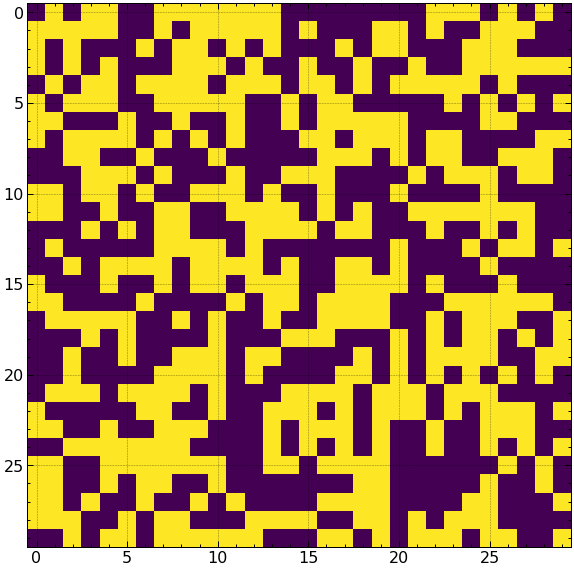

In [6]:
%time field=init(1,Nx,Ny)
plt.figure(figsize=(10,10))
plt.imshow(field)

In [8]:
#calcoliamo i primi vicini
%time npp,nmm = boundaries_cond(Nx,Ny)

CPU times: user 598 µs, sys: 1.75 ms, total: 2.34 ms
Wall time: 4.57 ms


In [6]:
len(npp)

30

In [9]:
@njit("(f8[:,:],f8)",parallel=True, cache=True)
def metropolis(field, beta):
    nvol=int(field.shape[0]*field.shape[1])
    for i in prange(0,nvol):
        x = int(np.random.uniform(0,1) * Nx)    #python indicizza da 0 a n-1 per a[n]
        y = int(np.random.uniform(0,1) * Ny)
        
        xp = npp[x]
        xm = nmm[x]
        yp = npp[y]
        ym = nmm[y]
        
        f = beta * (field[x][yp] + field[x][ym] + field[xp][y] + field[xm][y] + f_ext)   #calcolo la 'forza' + eventuale campo esterno
        
        s_i = field[x][y]    #spin attuale
        
        p_rat = np.exp(-2 * f * s_i)
        r = np.random.uniform(0,1)     #test accettanza
        
        if(r < p_rat):
            field[x][y] = -1*s_i
     

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
%time metropolis(field,0.2)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(field)

In [ ]:
def update(beta, it):
    field=init(1, Nx, Ny)
    snapshots =np.zeros((11,Nx,Ny))
    for i in range(it):
        metropolis(field,beta)
        if(i%int(it/10)==0):
            ii=int(i/(it/10))
            snapshots[ii,:,:]=field        
    return field,snapshots

In [ ]:
field=init(1,Nx,Ny)
plt.imshow(field)

In [ ]:
a=np.zeros((11,Nx,Ny))
%time field,a=update(0.6, 15000)

In [ ]:
#plotting snapshots
plt.figure(figsize=(20,20))
plt.title('') 
for k in range(1,11):
     
    plt.subplot(5, 5, k)# Address proper subplot in 2x2 array
    plt.title(r"$a_{%d}$"%(k-1))
    plt.imshow(a[k-1,:,:])

plt.show()

#The transitions occur for beta value around at $\beta=0.44$ 

In [ ]:
field=init(1,Nx,Ny)
plt.imshow(field)

In [10]:
@njit
def energy(field):
    ene=0.0
    for x in prange(field.shape[0]):
        for y in range(field.shape[1]):
            xp = npp[x]
            xm = nmm[x]
            yp = npp[y]
            ym = nmm[y]
            f = field[x][yp] + field[x][ym] + field[xp][y] + field[xm][y]
            ene = ene -  0.5*f*field[x,y]
            ene = ene - f_ext*field[x,y]
    ene = ene/(Nx*Ny)
    return ene      

In [11]:
@njit("f8(f8[:,:])")
def magnetization(field):
    magn=0.0
    for x in prange(0, field.shape[0]):
        for y in prange(0, field.shape[1]):
            magn += field[x,y]
    magn = magn/(field.shape[0]*field.shape[1])
    return magn

In [ ]:
field = init(1,Nx,Ny)
%time magnetization(field)

In [ ]:
%time ene=energy(a[9,:,:])
ene

In [12]:
try_steps=list(range(0,10000,1000))
snaps=[]
steps=[]
betas=[]
ene=[]
beta = np.arange(0.1,0.7,0.05)


In [ ]:
len(beta)*len(try_steps)

In [13]:
def best_it():
    file = open("best_it.txt", "a")
    #file.write("Num_iter\tbeta\tenergy\n")
    for i in tqdm(try_steps):
        for b in tqdm(beta):
            field,a = update(b,i)
            #steps.append(i)
            #betas.append(b)
            #ene.append(energy(field))
            file.write("%i\t%f\t%f\n"%(i,b,energy(field)))
    file.close()
                

In [14]:
file=open("best_it.txt","r")
ite, bs, es =np.loadtxt("best_it.txt",unpack=True, skiprows=1)

In [15]:
asmatrix =np.column_stack((ite,bs,es))


In [16]:
iiiit= asmatrix[:,1]

In [17]:
asmatrix[(iiiit==0.1),0]

array([ 10000.,  12500.,  15000.,  17500.,  20000.,  22500.,  25000.,
        27500.,  30000.,  32500.,  35000.,  37500.,  40000.,  42500.,
        45000.,  47500.,  50000.,  52500.,  55000.,  57500.,  60000.,
        62500.,  65000.,  67500.,  70000.,  72500.,  75000.,  77500.,
        80000.,  85000.,  90000.,  95000., 100000., 105000.,      0.,
         1000.,   2000.,   3000.,   4000.,   5000.,   6000.,   7000.,
         8000.,   9000.])

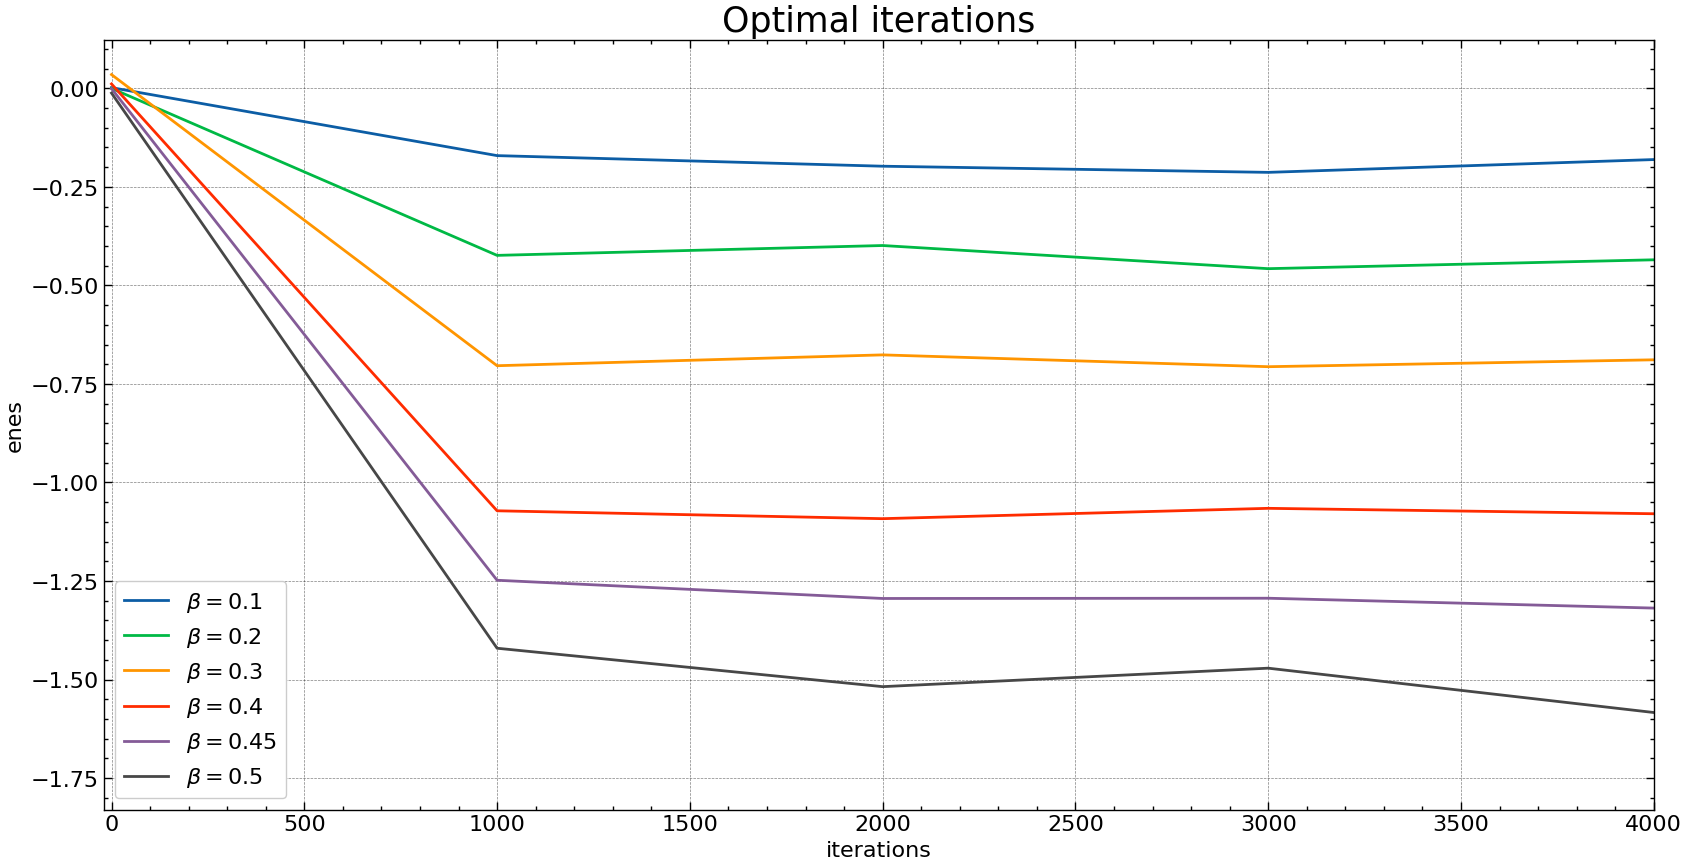

In [25]:
#Different values to understand which is the optimal value of iterations for thermalization
m = asmatrix[(iiiit==0.5),0]
n = asmatrix[(iiiit==0.5),2]
indices_sort = np.argsort(m)
iterations=m[indices_sort]
ene_sorted=n[indices_sort]


m1 = asmatrix[(iiiit==0.1),0]
n1 = asmatrix[(iiiit==0.1),2]
indices_sort1 = np.argsort(m1)
iterations1=m1[indices_sort1]
ene_sorted1=n1[indices_sort1]


m2 = asmatrix[(iiiit==0.45),0]
n2 = asmatrix[(iiiit==0.45),2]
indices_sort2 = np.argsort(m2)
iterations2=m2[indices_sort2]
ene_sorted2=n2[indices_sort2]


m3 = asmatrix[(iiiit==0.4),0]
n3 = asmatrix[(iiiit==0.4),2]
indices_sort3 = np.argsort(m3)
iterations3=m3[indices_sort3]
ene_sorted3=n3[indices_sort3]


m4 = asmatrix[(iiiit==0.2),0]
n4 = asmatrix[(iiiit==0.2),2]
indices_sort4 = np.argsort(m4)
iterations4=m4[indices_sort4]
ene_sorted4=n4[indices_sort4]


m5 = asmatrix[(iiiit==0.3),0]
n5 = asmatrix[(iiiit==0.3),2]
indices_sort5 = np.argsort(m5)
iterations5=m5[indices_sort5]
ene_sorted5=n5[indices_sort5]

plt.figure(figsize=(20,10))
plt.plot(iterations1,ene_sorted1,label=r'$\beta=0.1$')
plt.plot(iterations4,ene_sorted4,label=r'$\beta=0.2$')
plt.plot(iterations5,ene_sorted5,label=r'$\beta=0.3$')
plt.plot(iterations3, ene_sorted3,label=r'$\beta=0.4$')
plt.plot(iterations2, ene_sorted2,label=r'$\beta=0.45$')
plt.plot(iterations,ene_sorted,label=r'$\beta=0.5$')


plt.title('Optimal iterations',font='Sans', size=25)
plt.ylabel('enes')
plt.xlabel('iterations')
plt.xlim(-20,4000)
plt.legend()
plt.show()

## Simulation / Actual experiment

In [8]:
beta_exp = np.round(np.arange(0.3,0.55,0.001), decimals=3)
beta_exp_try = np.round(np.arange(0.3,0.31,0.001), decimals=3)
dim = np.arange(10,110,10)
dim_try =np.arange(10,30,10)
#for simplicity let's consider only a square like lattice




save_measure=100
measures=100000
measures_try=10000

In [ ]:
@njit
def update(beta, it):
    for i in range(it):
        metropolis(field,beta)      
    return field

In [20]:
def sim(beta, measures):
    with open('simulation_try.txt',"w") as file:
        file.write("#meas\tbeta\tEnergy\tMagn\n")
        for bs in tqdm(beta):
            field = init(1, Nx, Ny)
            for meas in range(measures):
                metropolis(field, bs)
                #if(meas%save_measure==0):
                    #file.write("%f\t%f\t%f\t%f\n"%(meas,bs,energy(field),magnetization(field)))

In [ ]:
sim(beta_exp_try, measures_try)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
m = []
for meas in range(measures):
    if(meas%save_measure==0):
        m.append(meas)

In [ ]:
len(m)

In [ ]:
Nx